In [1]:
import os
dataset_path = '../input/dataset/data/test/open eyes'
files = os.listdir(dataset_path)
print(f"Number of files: {len(files)}")

Number of files: 1657


In [24]:
import cv2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import MobileNet
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam


In [4]:
img_array = cv2.imread("../input/dataset/data/train/close eyes/s0001_00001_0_0_0_0_0_01.png",cv2.IMREAD_GRAYSCALE)

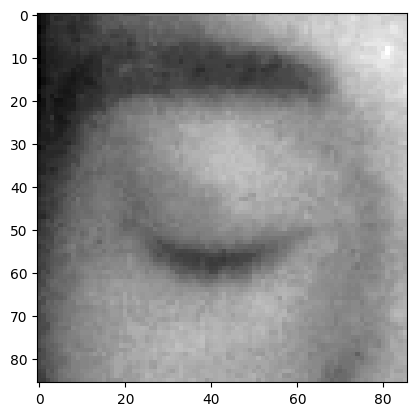

In [5]:
plt.imshow(img_array,cmap="gray")

In [6]:
img_array.shape

(86, 86)

In [14]:
train_dir = '../input/dataset/data/train'
test_dir = '../input/dataset/data/test'

def create_dataframe(directory):
    data = []
    for category in ['close eyes', 'open eyes']:
        path = os.path.join(directory, category)
        for img in os.listdir(path):
            img_path = os.path.join(path, img)
            data.append([img_path, category])
    return pd.DataFrame(data, columns=['image_path', 'label'])

df_train = create_dataframe(train_dir)
df_test = create_dataframe(test_dir)

In [15]:
df_train

,image_path,label
0,../input/dataset/data/train/close eyes/s0007_0...,close eyes
1,../input/dataset/data/train/close eyes/s0037_0...,close eyes
2,../input/dataset/data/train/close eyes/s0031_0...,close eyes
3,../input/dataset/data/train/close eyes/s0037_0...,close eyes
4,../input/dataset/data/train/close eyes/s0018_0...,close eyes
...,...,...
81670,../input/dataset/data/train/open eyes/s0028_00...,open eyes
81671,../input/dataset/data/train/open eyes/s0019_04...,open eyes
81672,../input/dataset/data/train/open eyes/s0032_01...,open eyes
81673,../input/dataset/data/train/open eyes/s0036_04...,open eyes


In [9]:
df_test

,image_path,label
0,../input/dataset/data/test/close eyes/s0002_00...,close eyes
1,../input/dataset/data/test/close eyes/s0002_00...,close eyes
2,../input/dataset/data/test/close eyes/s0003_00...,close eyes
3,../input/dataset/data/test/close eyes/s0002_00...,close eyes
4,../input/dataset/data/test/close eyes/s0002_00...,close eyes
...,...,...
3218,../input/dataset/data/test/open eyes/s0001_024...,open eyes
3219,../input/dataset/data/test/open eyes/s0001_023...,open eyes
3220,../input/dataset/data/test/open eyes/s0001_031...,open eyes
3221,../input/dataset/data/test/open eyes/s0001_024...,open eyes


In [16]:
train_df, valid_df = train_test_split(df_train, test_size=0.2, stratify=df_train['label'], random_state=42)

In [18]:
# Modified ImageDataGenerator with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.8,1.2],
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create generators
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_path',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'  # Changed to categorical
)

valid_generator = valid_datagen.flow_from_dataframe(
    dataframe=valid_df,
    x_col='image_path',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'  # Changed to categorical
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=df_test,
    x_col='image_path',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'  # Changed to categorical
)


Found 65340 validated image filenames belonging to 2 classes.
Found 16335 validated image filenames belonging to 2 classes.
Found 3223 validated image filenames belonging to 2 classes.


In [12]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Updated path to the weights file
base_model = MobileNet(weights=None, input_shape=(224, 224, 3), alpha=1.0, include_top=False)
base_model.load_weights("../input/mobilenet/mobilenet_1_0_224_tf_no_top.h5")  # Updated path

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

# Build the model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [13]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss')

# Train the model
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=5,
    callbacks=[early_stopping, model_checkpoint]
)



Epoch 1/5


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2042/2042 ━━━━━━━━━━━━━━━━━━━━ 1794s 876ms/step - accuracy: 0.9583 - loss: 0.1144 - val_accuracy: 0.9759 - val_loss: 0.0639
Epoch 2/5
2042/2042 ━━━━━━━━━━━━━━━━━━━━ 1797s 880ms/step - accuracy: 0.9801 - loss: 0.0561 - val_accuracy: 0.9832 - val_loss: 0.0439
Epoch 3/5
2042/2042 ━━━━━━━━━━━━━━━━━━━━ 1776s 870ms/step - accuracy: 0.9837 - loss: 0.0455 - val_accuracy: 0.9854 - val_loss: 0.0395
Epoch 4/5
2042/2042 ━━━━━━━━━━━━━━━━━━━━ 1732s 848ms/step - accuracy: 0.9846 - loss: 0.0427 - val_accuracy: 0.9862 - val_loss: 0.0372
Epoch 5/5
2042/2042 ━━━━━━━━━━━━━━━━━━━━ 1725s 845ms/step - accuracy: 0.9862 - loss: 0.0383 - val_accuracy: 0.9856 - val_loss: 0.0408


In [16]:
model.save('drowsiness_detection_model.h5')
print("Model saved successfully")

Model saved successfully


In [17]:
import tensorflow as tf
new_model = tf.keras.models.load_model('drowsiness_detection_model.h5')

In [18]:
print(os.listdir("/kaggle/input/openimg/"))


['new.png']


In [19]:
img_size = 224
img_array = cv2.imread('/kaggle/input/closedimg/c.jpg',cv2.IMREAD_GRAYSCALE)
backtorgb = cv2.cvtColor(img_array, cv2.COLOR_GRAY2RGB)
new_array = cv2.resize(backtorgb, (img_size, img_size))

In [20]:
X_input = np.array(new_array).reshape(1,img_size,img_size,3)

In [21]:
X_input.shape

(1, 224, 224, 3)

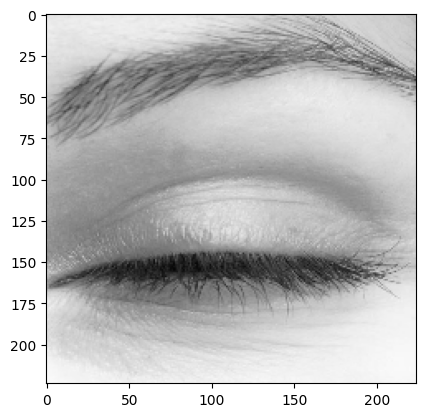

In [22]:
plt.imshow(new_array)

In [23]:
X_input = X_input/255.0

In [24]:
prediction = new_model.predict(X_input)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 742ms/step


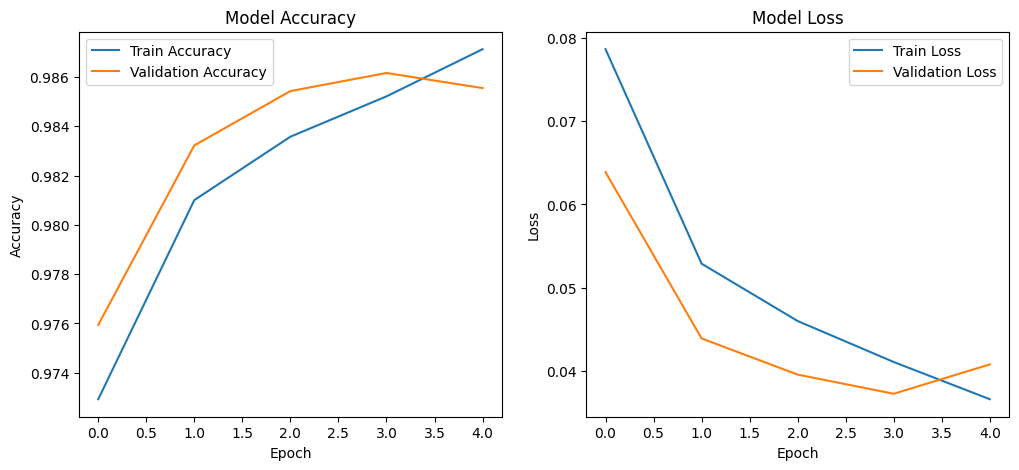

In [26]:
# Function to plot model performance
def plot_performance(history):
    plt.figure(figsize=(12, 5))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# After training the model, call the function to plot performance
plot_performance(history)

In [27]:
test_loss, test_accuracy = new_model.evaluate(test_generator)

# Print test loss and accuracy
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

101/101 ━━━━━━━━━━━━━━━━━━━━ 68s 660ms/step - accuracy: 0.8390 - loss: 0.5756
Test Loss: 0.5438
Test Accuracy: 0.8483


In [28]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
# Generate predictions on the test set
y_pred = new_model.predict(test_generator)
y_pred = np.round(y_pred).astype(int)  # Convert probabilities to binary labels (0 or 1)

# Get true labels from the test generator
y_true = test_generator.classes  # True labels

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)

101/101 ━━━━━━━━━━━━━━━━━━━━ 68s 658ms/step


In [32]:
import tensorflow as tf
new_model = tf.keras.models.load_model('../input/best-model/best_model.keras')

In [33]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model_new.keras', save_best_only=True, monitor='val_loss')

# Train the model
history = new_model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=5,
    callbacks=[early_stopping, model_checkpoint]
)



Epoch 1/5


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2042/2042 ━━━━━━━━━━━━━━━━━━━━ 1611s 787ms/step - accuracy: 0.9874 - loss: 0.0356 - val_accuracy: 0.9863 - val_loss: 0.0397
Epoch 2/5
2042/2042 ━━━━━━━━━━━━━━━━━━━━ 1603s 785ms/step - accuracy: 0.9885 - loss: 0.0336 - val_accuracy: 0.9866 - val_loss: 0.0357
Epoch 3/5
2042/2042 ━━━━━━━━━━━━━━━━━━━━ 1558s 763ms/step - accuracy: 0.9899 - loss: 0.0301 - val_accuracy: 0.9886 - val_loss: 0.0326
Epoch 4/5
2042/2042 ━━━━━━━━━━━━━━━━━━━━ 1569s 768ms/step - accuracy: 0.9899 - loss: 0.0286 - val_accuracy: 0.9870 - val_loss: 0.0338
Epoch 5/5
2042/2042 ━━━━━━━━━━━━━━━━━━━━ 1625s 789ms/step - accuracy: 0.9901 - loss: 0.0269 - val_accuracy: 0.9870 - val_loss: 0.0345


In [35]:
new_model.save('/kaggle/working/best_model_new.keras')


In [52]:
import tensorflow as tf
new_model = tf.keras.models.load_model('../input/best-model-new/best_model_new.keras')

In [53]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
# Generate predictions on the test set
y_pred = new_model.predict(test_generator)
y_pred = np.round(y_pred).astype(int)  # Convert probabilities to binary labels (0 or 1)

# Get true labels from the test generator
y_true = test_generator.classes  # True labels

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


101/101 ━━━━━━━━━━━━━━━━━━━━ 64s 623ms/step


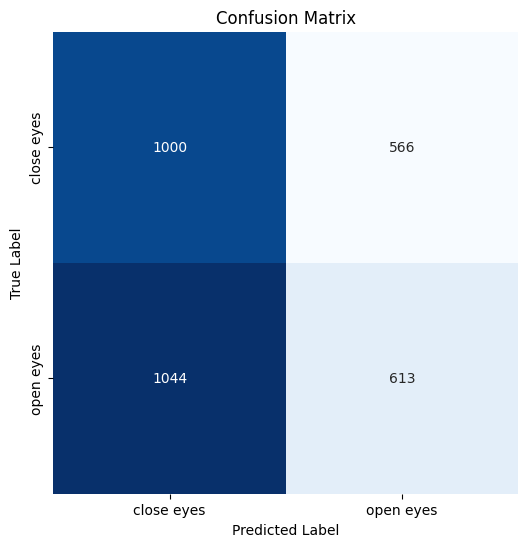

In [54]:
# Plot the confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=list(test_generator.class_indices.keys()), 
            yticklabels=list(test_generator.class_indices.keys()))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [7]:
import tensorflow as tf
new_model = tf.keras.models.load_model('../input/best-model-new/best_model_new.keras')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Predicted Probabilities: [[0.85977834]]
Predicted Class: open eyes


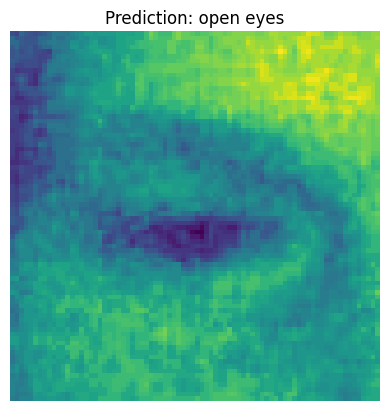

In [22]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
# Define class labels
classes = ['close eyes', 'open eyes']
path = "/kaggle/input/dataset/data/train/open eyes/s0007_00621_0_0_1_0_0_01.png"
img = Image.open(path)
img = img.resize((224, 224))
img_array = np.array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = np.expand_dims(img_array, axis=-1)
img_array = np.repeat(img_array, 3, axis=-1)
img_array = img_array / 255.0  # Normalize

# Predict
prediction = new_model.predict(img_array)
predicted_index = (prediction > 0.5).astype(int)[0, 0]  # Convert sigmoid output to class index

# Display results
print(f"Predicted Probabilities: {prediction}")
print(f"Predicted Class: {classes[predicted_index]}")

# Show the image
plt.imshow(Image.open(path))
plt.title(f"Prediction: {classes[predicted_index]}")
plt.axis("off")
plt.show()


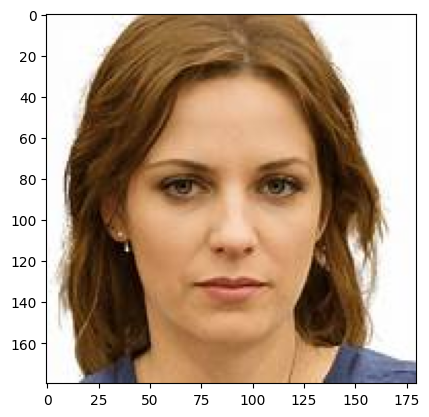

In [36]:
img=cv2.imread("/kaggle/input/woman-img/sad_woman.jpg")
rgb_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(rgb_image)

In [37]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_eye.xml")


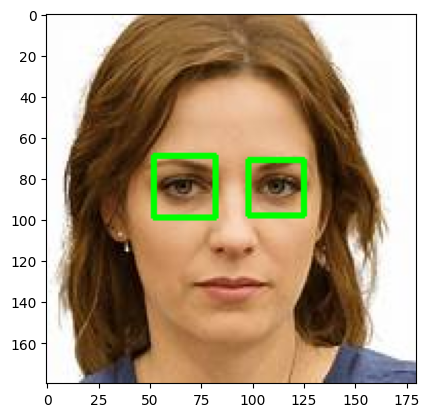

In [38]:
gray= cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
eyes= eye_cascade.detectMultiScale (gray, 1.1,4)
for(x, y, w, h) in eyes: 
    cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [39]:
eye_cascade = cv2.CascadeClassifier (cv2.data.haarcascades +'haarcascade_eye.xml')
gray= cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#print(faceCascade.empty())
eyes =eye_cascade.detectMultiScale(gray, 1.1,4)

for x,y,w,h in eyes:
    roi_gray= gray[y:y+h, x:x+w]
    roi_color= img[y:y+h, x:x+w]
    eyess =eye_cascade.detectMultiScale(roi_gray)
    if len(eyess) == 0:
        print("eyes are not detected")
    else:
        for (ex, ey, ew, eh) in eyess:
            eyes_roi =roi_color[ey: ey+eh, ex:ex + ew]

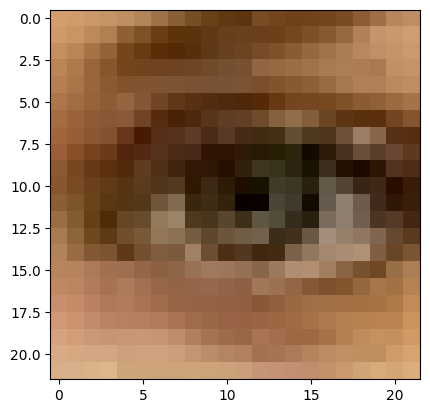

In [40]:
gray= cv2.cvtColor(eyes_roi, cv2.COLOR_BGR2RGB)
plt.imshow(gray)

In [41]:
gray.shape



(22, 22, 3)

In [42]:
final_image =cv2.resize(gray, (224,224))
final_image= np.expand_dims(final_image, axis= 0) ## need fourth dimension
final_image =final_image/255.0

In [43]:
final_image.shape

(1, 224, 224, 3)

In [44]:
# Predict
prediction = new_model.predict(img_array)
predicted_index = (prediction > 0.5).astype(int)[0, 0]  # Convert sigmoid output to class index

# Display results
print(f"Predicted Probabilities: {prediction}")
print(f"Predicted Class: {classes[predicted_index]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Predicted Probabilities: [[0.85977834]]
Predicted Class: open eyes


In [48]:
import cv2
import numpy as np


# Initialize Haar cascades
faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
eyeCascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')

# Load trained model (initialize properly)
# new_model = ... (Your pre-trained model)

cap = cv2.VideoCapture(1)
if not cap.isOpened():
    cap = cv2.VideoCapture(0)
if not cap.isOpened():
    raise IOError("Cannot open webcam")

# Beep parameters
frequency = 2500
duration = 1000
counter = 0  # Drowsiness counter

while True:
    ret, frame = cap.read()
    if not ret:
        break

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    eyes = eyeCascade.detectMultiScale(gray, 1.1, 4)
    for (x, y, w, h) in eyes:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = frame[y:y+h, x:x+w]
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)

    faces = faceCascade.detectMultiScale(gray, 1.1, 4)
    for (x, y, w, h) in faces:
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)

    if len(eyes) > 0:
        ex, ey, ew, eh = eyes[0]
        eyes_roi = frame[ey:ey+eh, ex:ex+ew]

        # Ensure valid ROI
        if eyes_roi.size > 0:
            final_image = cv2.resize(eyes_roi, (224, 224))
            final_image = np.expand_dims(final_image, axis=0)  # Add batch dimension
            final_image = final_image / 255.0  # Normalize

            # Prediction
            predictions = new_model.predict(final_image)
            predicted_index = (predictions > 0.5).astype(int)[0, 0]  # Convert to class

            font = cv2.FONT_HERSHEY_SIMPLEX
            
            if predicted_index == 1:  # Open Eyes
                status = "Open Eyes"
                counter = 0  # Reset drowsiness counter
                cv2.putText(frame, status, (150, 150), font, 3, (0, 255, 0), 2, cv2.LINE_4)
                cv2.rectangle(frame, (0, 0), (175, 75), (0, 0, 0), -1)
                cv2.putText(frame, 'Active', (25, 50), font, 0.7, (0, 255, 0), 2)
            
            else:  # Closed Eyes
                counter += 1
                status = "Closed Eyes"
                cv2.putText(frame, status, (150, 150), font, 3, (0, 0, 255), 2, cv2.LINE_4)
                cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 0, 255), 2)

                if counter > 5:  # Trigger alert after 5 frames
                    cv2.rectangle(frame, (0, 0), (175, 75), (0, 0, 0), -1)
                    cv2.putText(frame, 'Sleep Alert !!', (25, 50), font, 0.7, (0, 0, 255), 2)
                    os.system("play -nq -t alsa synth 1 sine 2500")  # Linux/Mac alternative
                    counter = 0  # Reset counter after alert

    cv2.imshow('Drowsiness Detection', frame)
    if cv2.waitKey(2) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


[ WARN:0@1281.227] global cap_v4l.cpp:999 open VIDEOIO(V4L2:/dev/video1): can't open camera by index
[ERROR:0@1281.228] global obsensor_uvc_stream_channel.cpp:158 getStreamChannelGroup Camera index out of range
[ WARN:0@1281.229] global cap_v4l.cpp:999 open VIDEOIO(V4L2:/dev/video0): can't open camera by index
[ERROR:0@1281.229] global obsensor_uvc_stream_channel.cpp:158 getStreamChannelGroup Camera index out of range


OSError: Cannot open webcam